Notes from https://github.com/Junyoungpark/GNNAtoZ 

# 0. Bring Your Own Graphs

In [ ]:
## Instantiating a graph  
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph() # instantiate an empty container for handling graph
G.add_node(1) # Add node in the graph
G.add_node(2) # Add node in the graph
G.add_node(3) # Add node in the graph

G.add_edge(1,2)
G.add_edge(2,3)

nx.draw(G)

In [ ]:
## DGL

import dgl
import torch

In [ ]:
# edges 0->1, 0->2, 0->3, 1->3
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g)

In [ ]:
g = dgl.graph((u, v), num_nodes=8)
print(g)

In [ ]:
node_feat_dim = 7 # the node feature dim
edge_feat_dim = 3 # the edge feature dim

g.ndata['feat'] = torch.randn(g.number_of_nodes(), node_feat_dim)
g.edata['feat'] = torch.randn(g.number_of_edges(), edge_feat_dim)
print(g)

In [ ]:
def plot_dgl_graph(g):
    G = dgl.to_networkx(g)
    plt.figure(figsize=[10,5])
    options = {
        'node_color': 'blue',
        "edge_color": "red",
        'node_size': 20,
        'width': 1,
    }
    # pos = nx.spring_layout(g)
    # nx.draw_networkx(g, pos, **options)
    nx.draw(G, **options)
    plt.show()

In [ ]:
plot_dgl_graph(g)

# 1. Message Passing on DGL

In [ ]:
import dgl
import torch
import torch.nn as nn

In [ ]:
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
g = dgl.graph((u, v), num_nodes=8)
g = dgl.add_self_loop(g)

node_feat_dim = 32
edge_feat_dim = 3

g.ndata["feat"] = torch.randn(g.number_of_nodes(), node_feat_dim)
g.edata["feat"] = torch.randn(g.number_of_edges(), edge_feat_dim)

print(g)

In [ ]:
class MessagePassingGCN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MessagePassingGCN, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim, bias=False)

    def forward(self, g, nf):
        g = g.local_var() # make a local graph
        z = self.linear(nf)
        g.ndata["z"] = z

        g.pull(v=g.nodes(), message_func=self.message_func, reduce_func=self.reduce_func)
        
        # The operations happens in `g.pull`
        # 1. Message generation: In this case, the message is "source node feature."
        # 2. 'Push' the message to the destination nodes
        # 3. 'Reduce' the messages from the destination nodes
        # 4. Perform node update: In this case, we don't do.
        
        # For further details, refer to the dgl's API documents. 
        return g.ndata["h"]

    def message_func(self, edges):
        return {"z": edges.src["z"]}

    def reduce_func(self, nodes):
        return {"h": torch.sum(nodes.mailbox["z"], dim=1)}


In [ ]:
gc_out_dim = 256
gc = MessagePassingGCN(node_feat_dim, gc_out_dim)

In [ ]:
h_updated = gc(g, g.ndata['feat'])
print(h_updated.shape)

In [ ]:
%%timeit
h_updated = gc(g, g.ndata['feat'])

In [ ]:
# A slightly optimized verision of the simple GCN with dgl.function

class MessagePassingGCN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MessagePassingGCN, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim, bias=False)
        self.message_func = dgl.function.copy_src("z", "z")
        self.reduce_func = dgl.function.sum("z", "h")

    def forward(self, g, nf):
        g = g.local_var()
        z = self.linear(nf)
        g.ndata["z"] = z

        g.pull(v=g.nodes(), message_func=self.message_func, reduce_func=self.reduce_func)
        return g.ndata["h"]


In [ ]:
gc = MessagePassingGCN(node_feat_dim, gc_out_dim)

In [ ]:
h_updated = gc(g, g.ndata['feat'])
print(h_updated.shape)

In [ ]:
%%timeit
h_updated = gc(g, g.ndata['feat'])

# 2. Implement Famous GNNs

In [ ]:
import dgl
import torch
import dgl.nn.pytorch.conv as dglconv

In [ ]:
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
g = dgl.graph((u, v), num_nodes=8)
g = dgl.add_self_loop(g)

node_feat_dim = 32
edge_feat_dim = 3

g.ndata['feat'] = torch.randn(g.number_of_nodes(), node_feat_dim)
g.edata['feat'] = torch.randn(g.number_of_edges(), edge_feat_dim)

In [ ]:
gc_out_dim = 16

gc = dglconv.GraphConv(in_feats=node_feat_dim, out_feats=gc_out_dim)

In [ ]:
h_updated = gc(g, g.ndata['feat'])

In [ ]:
# Graph Attention Networks
gat = dglconv.GATConv(in_feats=node_feat_dim,
                      out_feats=gc_out_dim,
                      num_heads=4)

In [ ]:
h_updated_gat = gat(g, g.ndata['feat'])

In [ ]:
h_updated_gat.shape # [#.nodes x #. attn head x # out dim]

In [ ]:
g.ndata['feat']

In [ ]:
# mini batch

batched_g = dgl.batch([g, g])

In [ ]:
print("Number of graphs in the batched graphs : {} \n".format(batched_g.batch_size))

print("Total number of nodes : {}".format(batched_g.num_nodes()))
print("Total number of edges : {} \n".format(batched_g.num_edges()))
n_nodes = [i.item() for i in batched_g.batch_num_nodes()]
n_edges = [i.item() for i in batched_g.batch_num_edges()]

print("Per graph number of nodes : {}".format(n_nodes))
print("Per graph number of edges : {} \n".format(n_edges))

In [ ]:
h_updated_batched = gc(batched_g, batched_g.ndata['feat'])
print(h_updated_batched.shape) # take a look at that the first dimension of output is now doubled.

In [ ]:
# Graph Readouts

readout = h_updated.sum(dim=0)
print(readout.shape)
print(readout)

In [ ]:
g.ndata['updated_h'] = h_updated
readout = dgl.readout_nodes(g, 'updated_h', op='sum')

In [ ]:
print(readout.shape)
print(readout)

# 3. How to train GraphSAGE

In [ ]:
import torch
import dgl
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F

In [ ]:
dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0] # since it only has one graph :)

In [ ]:
plot_dgl_graph(graph)

In [ ]:
%%latex
\begin{equation}
h=\text{GraphSAGE}^{(2)}(\text{ReLU}((\text{GraphSAGE}^{(1)}(\mathcal{G}, X))))
\end{equation}

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(in_feats, hid_feats, aggregator_type="mean")
        self.conv2 = dglnn.SAGEConv(hid_feats, out_feats, aggregator_type="mean")

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
graph.ndata.keys()

In [ ]:
node_features = graph.ndata["feat"]
node_labels = graph.ndata["label"]
train_mask = graph.ndata["train_mask"]
val_mask = graph.ndata["val_mask"]
test_mask = graph.ndata["test_mask"]

n_features = node_features.shape[1]
n_labels = len(node_labels.unique())

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [ ]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(100):
    model.train()
    # forward prop by using all nodes
    logits = model(graph, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    
    # compute train & validation accuracy
    train_acc = evaluate(model, graph, node_features, node_labels, train_mask)
    val_acc = evaluate(model, graph, node_features, node_labels, val_mask)
    # backward prop
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f} | Val Acc {:.4f}".format(
        epoch, loss.item(), train_acc, val_acc))

In [ ]:
model(graph, node_features)

In [ ]:
logits = model(graph, node_features)
logits

In [ ]:
logits.max()

# Tensorflow Implementation

In [ ]:
import os; os.environ["DGLBACKEND"] = "tensorflow"

In [ ]:
import dgl

In [ ]:
import pandas as pd
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

In [ ]:
# corr based adjacency

data = df[["forecast_dt", "rt_plant_id", "production"]]
data = pd.pivot_table(data, index="forecast_dt", columns="rt_plant_id", values="production")

In [ ]:
import dgl
from dgl.data import DGLDataset
import tensorflow as tf
import numpy as np

class WindPowerDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="wind")

    def process(self):
        df = pd.read_parquet("data/wind/2019-01-24_outlier_removed.parquet")    
        weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]
        plant_mapping = {k:v for k,v in zip(np.sort(df.rt_plant_id.astype(int).unique()), range(df.rt_plant_id.nunique()))}
        df.rt_plant_id = df.rt_plant_id.map(plant_mapping)
        
        THRESHOLD = 0.5
        edges_data = df[["forecast_dt", "rt_plant_id", "production"]]
        edges_data = pd.pivot_table(edges_data, index="forecast_dt", columns="rt_plant_id", values="production")
        A = abs(edges_data.corr())
        A = A[A > THRESHOLD].fillna(0)
        long_df = pd.DataFrame()
        for i, row in A.iterrows():
            df_ = pd.DataFrame(list(zip(row.index, row)), columns=["Dst", "Weight"])
            df_ = df_[df_["Weight"] != 0]
            df_ = df_[df_["Dst"] != i]
            df_["Src"] = i
            long_df = long_df.append(df_)
        edges_data = long_df.reset_index(drop=True)[["Src", "Dst", "Weight"]]
        edge_features = tf.convert_to_tensor(edges_data['Weight'].numpy(), dtype=tf.float32)
        # edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = tf.convert_to_tensor(edges_data['Src'].numpy(), dtype=tf.float32)
        edges_dst = tf.convert_to_tensor(edges_data['Dst'].numpy(), dtype=tf.float32)
        
        nodes_data = df[["rt_plant_id", "forecast_dt", "production", *weather_cols]]
        nodes_data = nodes_data.reset_index(drop=True)
        nodes_data = nodes_data[nodes_data["forecast_dt"] == nodes_data["forecast_dt"].min()]
        node_features = tf.convert_to_tensor(nodes_data[weather_cols].numpy())
        node_labels = tf.convert_to_tensor(nodes_data["production"].numpy())
        
        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        
    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

# Pytorch Implementation

In [1]:
import dgl
import pandas as pd
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

[19:28:50Using backend: pytorch
] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.so: cannot open shared object file: No such file or directory


In [3]:
import scipy.sparse as sp
THRESHOLD = 0.5

edges_data = df[["forecast_dt", "rt_plant_id", "production"]]
A = abs(edges_data.corr())
A = A[A > THRESHOLD].fillna(0)
sp_mx = sp.coo_matrix(A)
G = dgl.from_scipy(sp_mx, eweight_name="weight")
G.adjacency_matrix()
# print(G.edata["weight"])

tensor(indices=tensor([[0, 1],
                       [0, 1]]),
       values=tensor([1., 1.]),
       size=(2, 2), nnz=2, layout=torch.sparse_coo)

In [17]:
import dgl
from dgl.data import DGLDataset
import torch
import numpy as np

class WindPowerDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="wind")

    def process(self):
        df = pd.read_parquet("../data/processed/outlier_removed.parquet")    
        weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]
        plant_mapping = {k:v for k,v in zip(np.sort(df.rt_plant_id.astype(int).unique()), range(df.rt_plant_id.nunique()))}
        df.rt_plant_id = df.rt_plant_id.map(plant_mapping)
        
        THRESHOLD = 0.5
        edges_data = df[["forecast_dt", "rt_plant_id", "production"]]
        edges_data = pd.pivot_table(edges_data, index="forecast_dt", columns="rt_plant_id", values="production")
        A = abs(edges_data.corr())
        A = A[A > THRESHOLD].fillna(0)
        long_df = pd.DataFrame()
        for i, row in A.iterrows():
            df_ = pd.DataFrame(list(zip(row.index, row)), columns=["Dst", "Weight"])
            df_ = df_[df_["Weight"] != 0]
            df_ = df_[df_["Dst"] != i]
            df_["Src"] = i
            long_df = long_df.append(df_)
        edges_data = long_df.reset_index(drop=True)[["Src", "Dst", "Weight"]]
        edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['Src'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())
        
        nodes_data = df[["rt_plant_id", "forecast_dt", "production", *weather_cols]]
        nodes_data = nodes_data.reset_index(drop=True)
        nodes_data = nodes_data[nodes_data["forecast_dt"] == nodes_data["forecast_dt"].min()]
        node_features = torch.from_numpy(nodes_data[weather_cols].to_numpy())
        node_labels = torch.from_numpy(nodes_data["production"].to_numpy())
        
        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        
    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [5]:
# https://github.com/dmlc/dgl/blob/master/examples/pytorch/gcn/gcn.py

"""GCN using DGL nn package
References:
- Semi-Supervised Classification with Graph Convolutional Networks
- Paper: https://arxiv.org/abs/1609.02907
- Code: https://github.com/tkipf/gcn
"""
import torch
import torch.nn as nn
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import dgl
from dgl.data import CoraGraphDataset

In [7]:
data = CoraGraphDataset() # len 1, num_nodes=2708, num_edges=10556

g = data[0]

features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
in_feats = features.shape[1]
n_classes = data.num_classes
n_edges = g.number_of_edges()
print("""----Data statistics------'
    #Edges %d
    #Classes %d
    #Train samples %d
    #Val samples %d
    #Test samples %d""" %
        (n_edges, n_classes,
            train_mask.int().sum().item(),
            val_mask.int().sum().item(),
            test_mask.int().sum().item()))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
----Data statistics------'
    #Edges 10556
    #Classes 7
    #Train samples 140
    #Val samples 500
    #Test samples 1000


In [8]:
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)
n_edges = g.number_of_edges()
print(n_edges)

13264


In [9]:
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0

In [10]:
g.ndata['norm'] = norm.unsqueeze(1)

In [11]:
args = {
    "n_hidden": 16,
    "dropout": 0.5,
    "n_layers": 1,
    "lr": 0.01,
    "n_epochs": 1000,
    "weight_decay": 5e-4
}

In [12]:
model = GCN(g,
            in_feats,
            args["n_hidden"],
            n_classes,
            args["n_layers"],
            F.relu,
            args["dropout"])

In [13]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=args["lr"], weight_decay=args["weight_decay"])


In [14]:
import time

def evaluate(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


dur = []
for epoch in range(args["n_epochs"]):
    model.train()
    if epoch >= 3:
        t0 = time.time()
    # forward
    logits = model(features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | Accuracy {:.4f} | "
            "ETputs(KTEPS) {:.2f}". format(epoch, np.mean(dur), loss.item(),
                                            acc, n_edges / np.mean(dur) / 1000))

print()
acc = evaluate(model, features, labels, test_mask)
print("Test accuracy {:.2%}".format(acc))

/home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mert/miniconda3/envs/thesis_torch/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Loss 1.9454 | Accuracy 0.1460 | ETputs(KTEPS) nan
Epoch 00001 | Time(s) nan | Loss 1.9400 | Accuracy 0.2900 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 1.9332 | Accuracy 0.3960 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.0082 | Loss 1.9232 | Accuracy 0.4180 | ETputs(KTEPS) 1612.93
Epoch 00004 | Time(s) 0.0079 | Loss 1.9147 | Accuracy 0.5580 | ETputs(KTEPS) 1670.09
Epoch 00005 | Time(s) 0.0083 | Loss 1.9053 | Accuracy 0.5980 | ETputs(KTEPS) 1603.00
Epoch 00006 | Time(s) 0.0081 | Loss 1.8925 | Accuracy 0.6060 | ETputs(KTEPS) 1631.66
Epoch 00007 | Time(s) 0.0079 | Loss 1.8821 | Accuracy 0.6180 | ETputs(KTEPS) 1688.38
Epoch 00008 | Time(s) 0.0078 | Loss 1.8671 | Accuracy 0.6240 | ETputs(KTEPS) 1699.24
Epoch 00009 | Time(s) 0.0078 | Loss 1.8608 | Accuracy 0.6320 | ETputs(KTEPS) 1709.68
Epoch 00010 | Time(s) 0.0077 | Loss 1.8505 | Accuracy 0.6420 | ETputs(KTEPS) 1713.41
Epoch 00011 | Time(s) 0.0078 | Loss 1.8322 | Accuracy 0.6520 | ETputs(KTEPS) 1695.41
E

In [18]:
dataset = WindPowerDataset()


In [19]:
dataset[0]

Graph(num_nodes=94, num_edges=5506,
      ndata_schemes={'feat': Scheme(shape=(8,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [20]:
graph = dataset[0]

print(graph)

Graph(num_nodes=94, num_edges=5506,
      ndata_schemes={'feat': Scheme(shape=(8,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


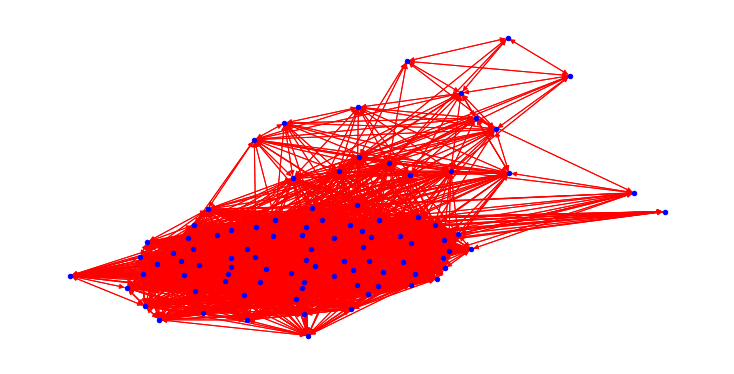

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_dgl_graph(g):
    G = dgl.to_networkx(g)
    plt.figure(figsize=[10,5])
    options = {
        'node_color': 'blue',
        "edge_color": "red",
        'node_size': 20,
        'width': 1,
    }
    # pos = nx.spring_layout(g)
    # nx.draw_networkx(g, pos, **options)
    nx.draw(G, **options)
    plt.show()
    
plot_dgl_graph(graph)